In [2]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats

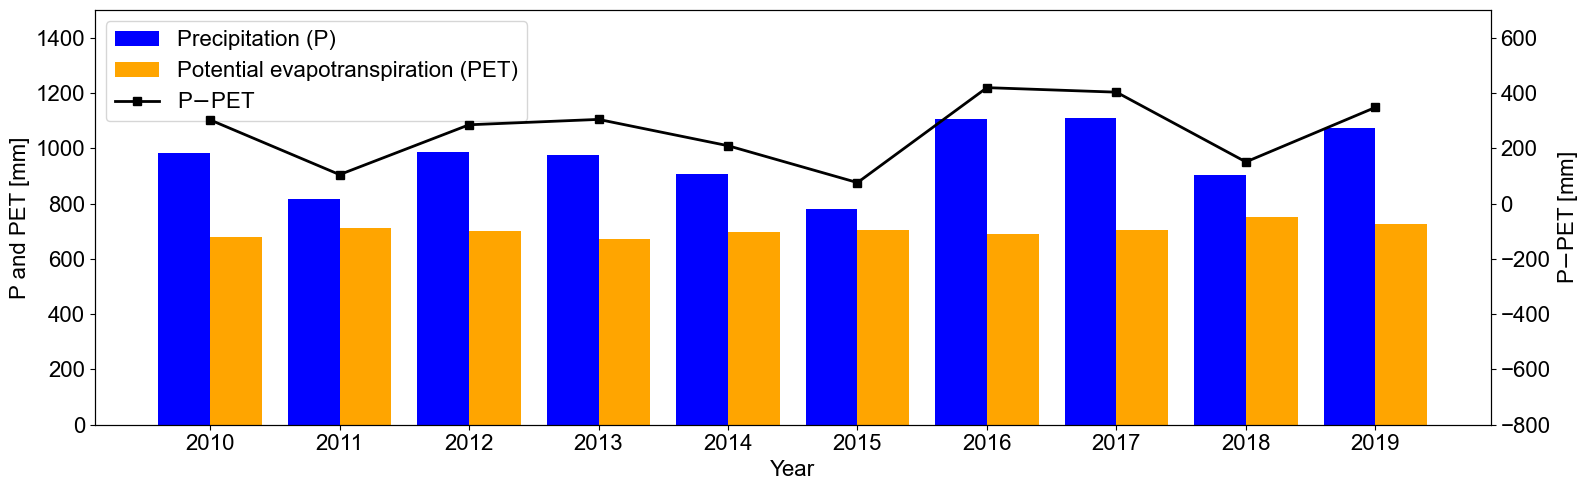

array([680.26988143, 712.31776361, 700.5256865 , 672.50126489,
       695.95273966, 703.37781421, 688.03052701, 705.73964413,
       750.94811821, 726.17928968])

In [21]:
def calculate_zonal_stats(raster_path, shp_path):
    # Get the number of bands in the raster
    with rasterio.open(raster_path) as src:
        num_bands = src.count

    # Initialize lists to store band indices and mean values
    band_indices = []
    mean_values = []

    # Loop through each band and calculate zonal statistics
    for band_index in range(1, num_bands + 1):
        year = 2010 + band_index - 1  # Calculate the corresponding year
        stats = zonal_stats(shp_path, raster_path, band=band_index, stats="mean")
        mean_value = stats[0]['mean']  # Assuming only one feature in the shapefile
        band_indices.append(year)
        mean_values.append(mean_value)

    return band_indices, mean_values

# Paths to the rasters and shapefile
et_path = 'e1019.tif'
prec_path = 'p1019.tif'
shp_path = 'rhine_basin.shp'

#zonal statistics for evapotranspiration raster
et_band_indices, et_mean_values = calculate_zonal_stats(et_path, shp_path)

#zonal statistics for precipitation raster
prec_band_indices, prec_mean_values = calculate_zonal_stats(prec_path, shp_path)
et_mean_values = np.array(et_mean_values)
prec_mean_values = np.array(prec_mean_values)

#positions for bars
bar_width = 0.4
prec_positions = np.arange(len(et_band_indices))
et_positions = prec_positions + bar_width

#bar plotting
fig, ax1 = plt.subplots(figsize=(16, 5))

# Plot for precipitation and evapotranspiration
prec_bar = ax1.bar(prec_positions, prec_mean_values, width=bar_width, label='Precipitation (P)', color='blue')
et_bar = ax1.bar(et_positions, et_mean_values, width=bar_width, label='Potential evapotranspiration (PET)', color='orange')


ax1.set_xlabel('Year', fontsize=16)
ax1.set_ylabel('P and PET [mm]', fontsize=16)
ax1.set_xticks(prec_positions + bar_width / 2)
ax1.set_xticklabels(et_band_indices, fontsize=16)
ax1.tick_params(axis='y', labelsize=16)
# ax1.set_title('Zonal Statistics - Mean Evapotranspiration and Precipitation for Each Year')

#secondary y-axis for the difference
ax2 = ax1.twinx()
diff = prec_mean_values - et_mean_values
diff_line = ax2.plot(prec_positions + bar_width / 2, diff, color='black', marker='s', linestyle='-', linewidth =2, label='P$-$PET')
ax2.set_ylabel('P$-$PET [mm]', fontsize=16)
ax2.tick_params(axis='y', labelsize=16)

# Set y-axis limits for the left y-axis
ax1.set_ylim(0, 1500)
ax2.set_ylim(-800, 700)

# Combine legends and move it to the left
bars, labels = ax1.get_legend_handles_labels()
lines, linelabels = ax2.get_legend_handles_labels()
ax1.legend(bars + lines, labels + linelabels, loc='upper left', fontsize=16)

fig.tight_layout()
plt.savefig('pet_p_rhine.jpg', format='jpg', dpi=500, bbox_inches='tight')
plt.show()
prec_mean_values
et_mean_values

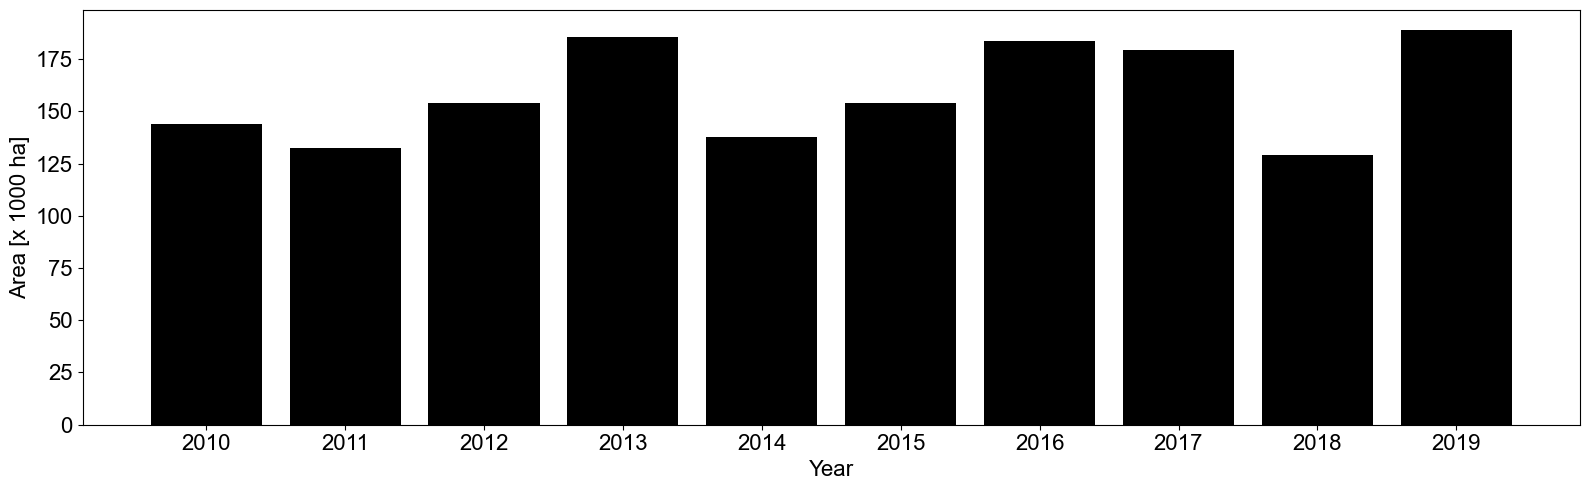

In [22]:
area = np.array([143.906291,
                 132.212881,
                 153.7531,
                 185.766506,
                 137.565352,
                 153.992029,
                 183.626607,
                 179.369423,
                 129.073196,
                 189.027676
                ])

# Create positions for bars
bar_width = 0.8
prec_positions = np.arange(len(et_band_indices))
et_positions = prec_positions + 0.4

# Plotting the bar graphs side by side
fig, ax1 = plt.subplots(figsize=(16, 5))
prec_bar = ax1.bar(et_positions, area, width=bar_width, label='Precipitation', color='black')

ax1.set_xlabel('Year', fontsize=16)
ax1.set_ylabel('Area [x 1000 ha]', fontsize=16)
ax1.set_xticks(prec_positions + bar_width / 2)
ax1.set_xticklabels(et_band_indices, fontsize=16)
ax1.tick_params(axis='y', labelsize=16)

fig.tight_layout()
# plt.savefig('rhine_area.jpg', format='jpg', dpi=500, bbox_inches='tight')
plt.show()

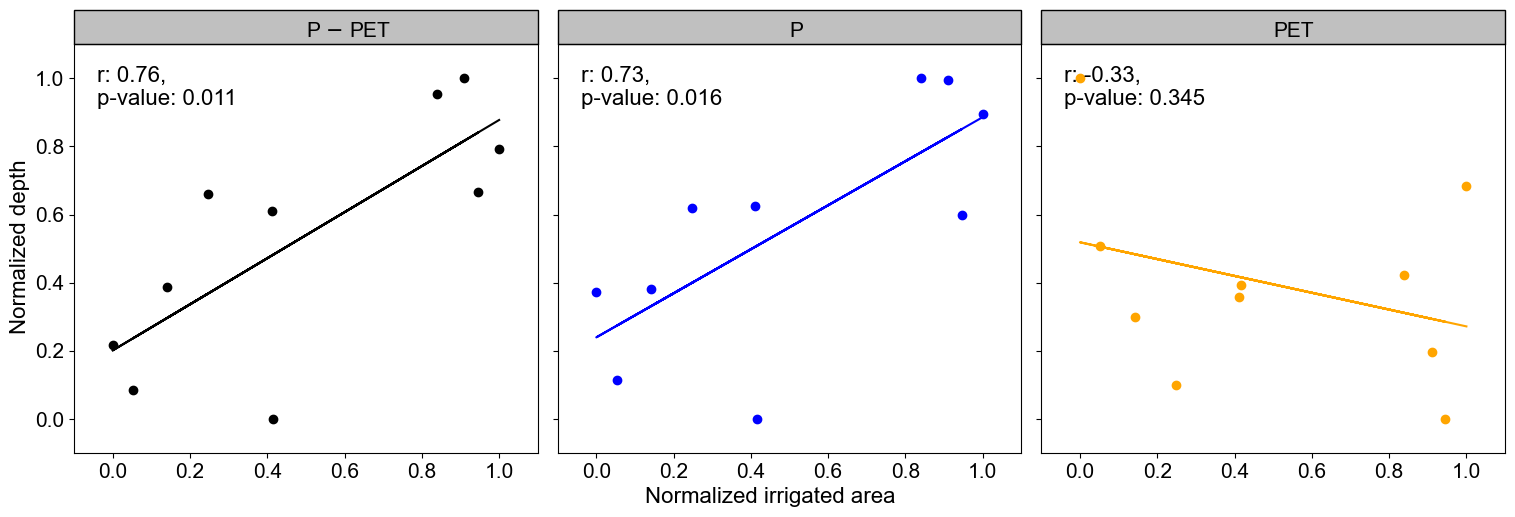

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

def plot_correlation(x, ys, labels, colors):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    
    for ax, y, label, color in zip(axs, ys, labels, colors):
        #Standardization
        x_standardized = (x - np.min(x)) / (np.max(x) - np.min(x))
        y_standardized = (y - np.min(y)) / (np.max(y) - np.min(y))
        
        #Pearson correlation coefficient and p-value
        correlation, p_value = pearsonr(x_standardized, y_standardized)
        
        #Fit linear regression
        regression = LinearRegression()
        regression.fit(x_standardized.reshape(-1, 1), y_standardized)
        y_pred = regression.predict(x_standardized.reshape(-1, 1))
        
        #plot
        ax.scatter(x_standardized, y_standardized, color=color, label=f'r={correlation:.2f}, p={p_value:.3f}')
        ax.annotate(f'r: {correlation:.2f},\np-value: {p_value:.3f}', xy=(0.05, 0.85), xycoords='axes fraction', fontsize=16)
        ax.plot(x_standardized, y_pred, color=color, linestyle='-')
#         ax.set_title(label, fontsize=15)
        ax.tick_params(axis='x', labelsize=15)
        ax.tick_params(axis='y', labelsize=15)
        ax.set_xlim(-0.1,1.1)
        ax.set_ylim(-0.1,1.1)

        rect = plt.Rectangle((-0.1, 1.1), 1.2, 0.1, facecolor='silver', edgecolor='black', linewidth=1, clip_on=False)
        ax.add_patch(rect)

        TITLE = ax.text(0.5, 1.12, f'{label}', fontsize=15, zorder=2, color='k')

    fig.text(0.5, 0, 'Normalized irrigated area', ha='center', va='center', fontsize=16)
    fig.text(0, 0.5, 'Normalized depth', ha='center', va='center', rotation='vertical', fontsize=16)
    plt.tight_layout()
#     plt.savefig('correlation_alsace.jpg', format='jpg', dpi=500, bbox_inches='tight')
    plt.show()

# Example
x = area
ys = [diff, prec_mean_values, et_mean_values]
labels = ['P $-$ PET', 'P', 'PET']
colors = ['black', 'blue', 'orange']

plot_correlation(x, ys, labels, colors)
